In [2]:
import os
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.models import load_model


In [3]:
import pandas as pd

data = pd.read_parquet('train-00000-of-00001-c08a401c53fe5312.parquet')
print(data.head())


                                               image  label
0  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      2
1  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      0
2  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      3
3  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      3
4  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      2


In [4]:
from PIL import Image
import io
import numpy as np

image_bytes = data.iloc[:, 0].apply(lambda x: x['bytes'])
labels = data.iloc[:, 1]

decoded_images = [Image.open(io.BytesIO(image)) for image in image_bytes]

labels_array = np.array(labels)


In [5]:
def preprocess_image(image, target_size=(128, 128)):
    image = image.convert('RGB')
    image = image.resize(target_size)
    image_array = np.array(image) / 255.0
    return image_array

processed_images = np.array([preprocess_image(img) for img in decoded_images])


In [6]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='leaky_relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='leaky_relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='leaky_relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='leaky_relu'),
    layers.Dropout(0.5),
    layers.Dense(len(np.unique(labels_array)), activation='softmax')  # Output layer
])

model.summary()

/home/revanth1206/Revanth/pyml/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-03-19 20:37:27.650292: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,156 (12.61 MB)

 Trainable params: 3,305,156 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history=model.fit(processed_images, labels_array, epochs=20, batch_size=32)

Epoch 1/20


E0000 00:00:1742396875.083794   38866 meta_optimizer.cc:966] remapper failed: INVALID_ARGUMENT: Mutation::Apply error: fanout 'StatefulPartitionedCall/gradient_tape/sequential_1/conv2d_1_2/LeakyRelu/LeakyReluGrad' exist for missing node 'StatefulPartitionedCall/sequential_1/conv2d_1_2/BiasAdd'.


160/160 ━━━━━━━━━━━━━━━━━━━━ 40s 241ms/step - accuracy: 0.5063 - loss: 1.0499
Epoch 2/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 31s 191ms/step - accuracy: 0.6201 - loss: 0.8595
Epoch 3/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 20s 124ms/step - accuracy: 0.7874 - loss: 0.5054
Epoch 4/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 20s 128ms/step - accuracy: 0.9208 - loss: 0.2173
Epoch 5/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 21s 132ms/step - accuracy: 0.9677 - loss: 0.0968
Epoch 6/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 21s 133ms/step - accuracy: 0.9868 - loss: 0.0384
Epoch 7/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 22s 136ms/step - accuracy: 0.9881 - loss: 0.0328
Epoch 8/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 21s 133ms/step - accuracy: 0.9936 - loss: 0.0189
Epoch 9/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - accuracy: 0.9889 - loss: 0.0306
Epoch 10/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 22s 135ms/step - accuracy: 0.9920 - loss: 0.0213
Epoch 11/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 21s 133ms/step - accuracy: 0.9953 - loss: 0.0125
Epoch 12/20
160/160 ━━━━━━━━━━

In [8]:
  # Save the model to a file
model.save('dementia_model_compare.h5')

In [9]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('dementia_model_compare.h5')

In [10]:
test_data = pd.read_parquet('test-00000-of-00001-44110b9df98c5585.parquet')

test_image_bytes = test_data.iloc[:, 0].apply(lambda x: x['bytes'])
test_labels = test_data.iloc[:, 1]

test_decoded_images = [Image.open(io.BytesIO(image)) for image in test_image_bytes]
test_processed_images = np.array([preprocess_image(img) for img in test_decoded_images])

test_labels_array = np.array(test_labels)

test_loss, test_accuracy = model.evaluate(test_processed_images, test_labels_array)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.9774 - loss: 0.1117
Test Accuracy: 97.81%


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

test_loss, test_accuracy = model.evaluate(test_processed_images, test_labels_array)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.9774 - loss: 0.1117
Test Loss: 0.0932, Test Accuracy: 0.9781


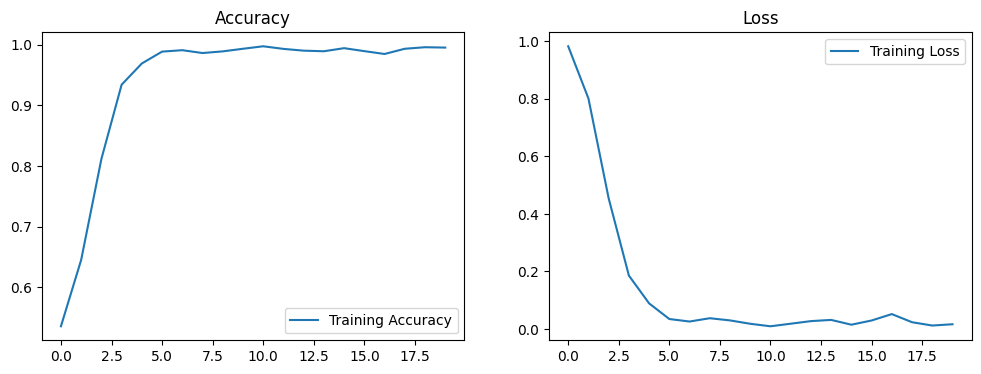

In [13]:
def plot_history(history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss')
    
    plt.show()


plot_history(history)

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       172
           1       1.00      0.87      0.93        15
           2       0.99      0.98      0.98       634
           3       0.95      1.00      0.97       459

    accuracy                           0.98      1280
   macro avg       0.98      0.95      0.96      1280
weighted avg       0.98      0.98      0.98      1280



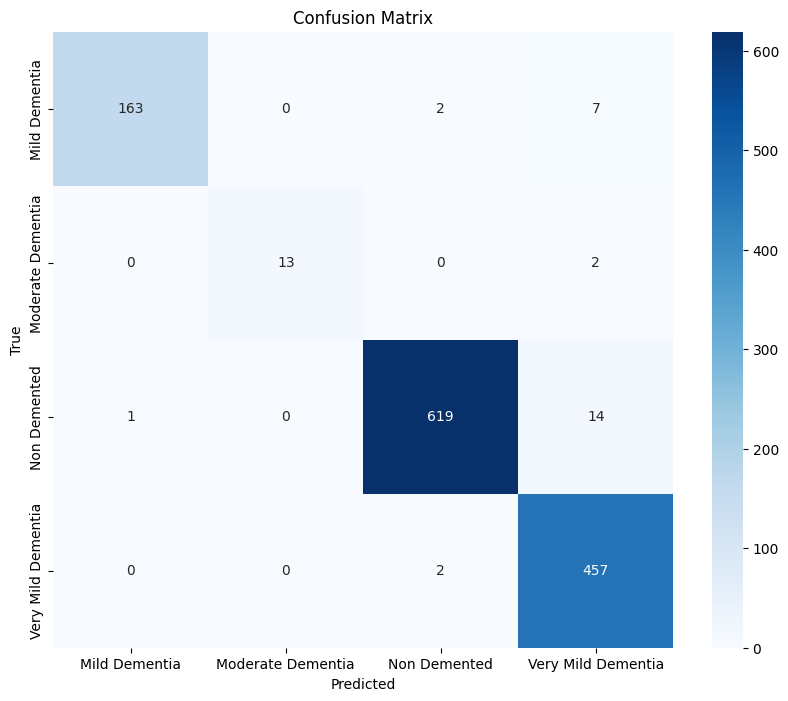

In [15]:
predictions = model.predict(test_processed_images)
y_pred = np.argmax(predictions, axis=1)
y_true = test_labels_array  

class_names = [str(i) for i in sorted(np.unique(y_true))]

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

class_names = ["Mild Dementia", "Moderate Dementia", "Non Demented", "Very Mild Dementia"]
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


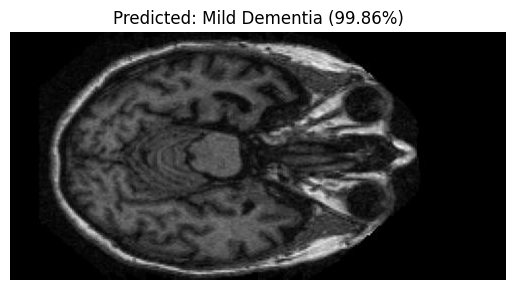

In [23]:
from PIL import Image
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image(image_path):
    image = Image.open(image_path)
    image = image.resize((128, 128))  
    image = np.array(image) / 255.0  
    if image.shape[-1] == 4:         
        image = image[:, :, :3]
    return image

test_image_path = r'archive/Data/Moderate Dementia/OAS1_0308_MR1_mpr-2_126.jpg'
test_image = preprocess_image(test_image_path)
test_image = np.expand_dims(test_image, axis=0)  

prediction = model.predict(test_image)
predicted_class = np.argmax(prediction)  
confidence = prediction[0][predicted_class] * 100  

class_labels = ["Mild Dementia", "Moderate Dementia", "Non Demented", "Very Mild Dementia"]
pred_label = class_labels[predicted_class]

plt.imshow(plt.imread(test_image_path))
plt.title(f"Predicted: {pred_label} ({confidence:.2f}%)")
plt.axis('off')
plt.show()
